# Data Visualization of the Global Historical Climatology Network-Daily Database

## Introducing the data

**What is the GHCN?**

As you can read from [NOAA website](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn):

>The Global Historical Climatology Network (GHCN) is an integrated database of climate summaries from land surface stations across the globe that have been subjected to a common suite of quality assurance reviews. The data are obtained from more than 20 sources. Some data are more than 175 years old while others are less than an hour old.

**The data**

You can download all the GHCN data from [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/).

For this project, we took the archive 'ghcnd_all.tar.gz'. As the name suggests, this archive contains all the data from the GHCN-Daily Database. Among many other files, it includes:
- a more than usefull readme.txt describing all the others files, including their columns widths (required for Pandas to read them)
- a fixed width file describing *108081* weather stations.
- a fixed width file containing the daily measures for each stations. In these 108081 files, each line represents a month of measures. The oldest measures are minimum and maximum temperatures from *January 1763* and there are up to *137* different types of measures!!! But not all of the 108081 stations have been working since 1763 and not all of them record 137 items. There are actually only 5 core elements measured:
  - PRCP: Precipitation in tenths of mm
  - SNOW: Snowfall in mm
  - SNWD: Snowdepth in mm
  - TMAX: Maximum temperature in tenths of degrees
  - TMIN: Minimum temperature in tenths of degrees

Still, at the time of this project, the daily files contain all together 103,440,334 lines, **roughly 3,206,650,354 measures!!**

## Strategy

I thought the best way to visualize such a big amount a data was to make a video of one or two element(s) (e.g. TMAX and/or PRCP) measured through time, plotted on a world map. As we will see, some places have a high density of weather stations wich is impossible to show as individual measures on a big scale. On the other hand, most of the globe has no station at all. This is a chance to geographically aggregate the data to decrease the number of points to display. Since I wanted to keep a good mapping resolution, I decided to aggregate the data in 2500 km² units called 'sectors'.

The second element to consider were the tools to store, process and plot the measures. My choice was to store all the data in a single SQLite database and to request, aggregate and plot the measures using respectively SQL queries, Pandas Dataframes and Matplotlib/Cartopy.

At last, I used [ffmpeg](https://www.ffmpeg.org/) to turn all the plots into a video.

## Building the sectors to aggregate the data

Though it is very likely that an existing algorithm is readily available for such a task, I decided to write my own simple piece of code to split the globe into 2500 km² units. It is a mathematical approximation based on a perfectly spherical Earth. Despite beeing wrong, it is very simple and the result is only 0.4% off compared to the actual Earth surface area. Take a look [here](http://www.longitudestore.com/how-big-is-one-gps-degree.html) for more explanations.

At the end of the algorithm, we have a list of 204823 sectors described by an id, the latitude and longitude of their 4 corners and their central point - wich will be used as x and y to plot the data. There are many more sectors than stations but most of them are in ocean (70% of the globe surface) where there are no stations and - once again - most of the lands have no station at all. Therefore, we will only need a small fraction of them.

In [17]:
from math import pi, cos, ceil
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Earth radius and perimeter and unit size (50km*50km=2500km²)
Pe=40075
Re=Pe/(2*pi)
unit_size=50

n_lat=ceil((Pe/2)/unit_size) #number of units per degree of latitude
i_lat = 180/n_lat #unit size in degrees of latitude

def count_lon(lat): #function to compute the number of units per degree of longitude according to the latitude
    return(ceil((Re*cos(pi*lat/180)*2*pi)/unit_size))

#initializing before the loop: empty sector list, start of the loop at -90° of latitude and i=j=0 
#are the counters for latitude and longitude
sector_list=[]
lat_min = -90
i=0

while i<n_lat:
    lat_max=lat_min+i_lat
    lon_min=-180
    n_lon=count_lon(lat_min)
    i_lon=360/n_lon
    j=0
    
    while j < n_lon:
        lon_max=lon_min+i_lon
        lat_cen=lat_min+i_lat/2
        lon_cen=lon_min+i_lon/2
        sector_list.append([lat_min,lat_max,lon_min,lon_max,lat_cen,lon_cen])
        lon_min+=i_lon
        j+=1
    
    lat_min=lat_min+i_lat
    i+=1
    
sectors_df=pd.DataFrame(sector_list,columns=['lat_min','lat_max','lon_min','lon_max','lat_cen','lon_cen'])
sectors_df.shape

(204823, 6)

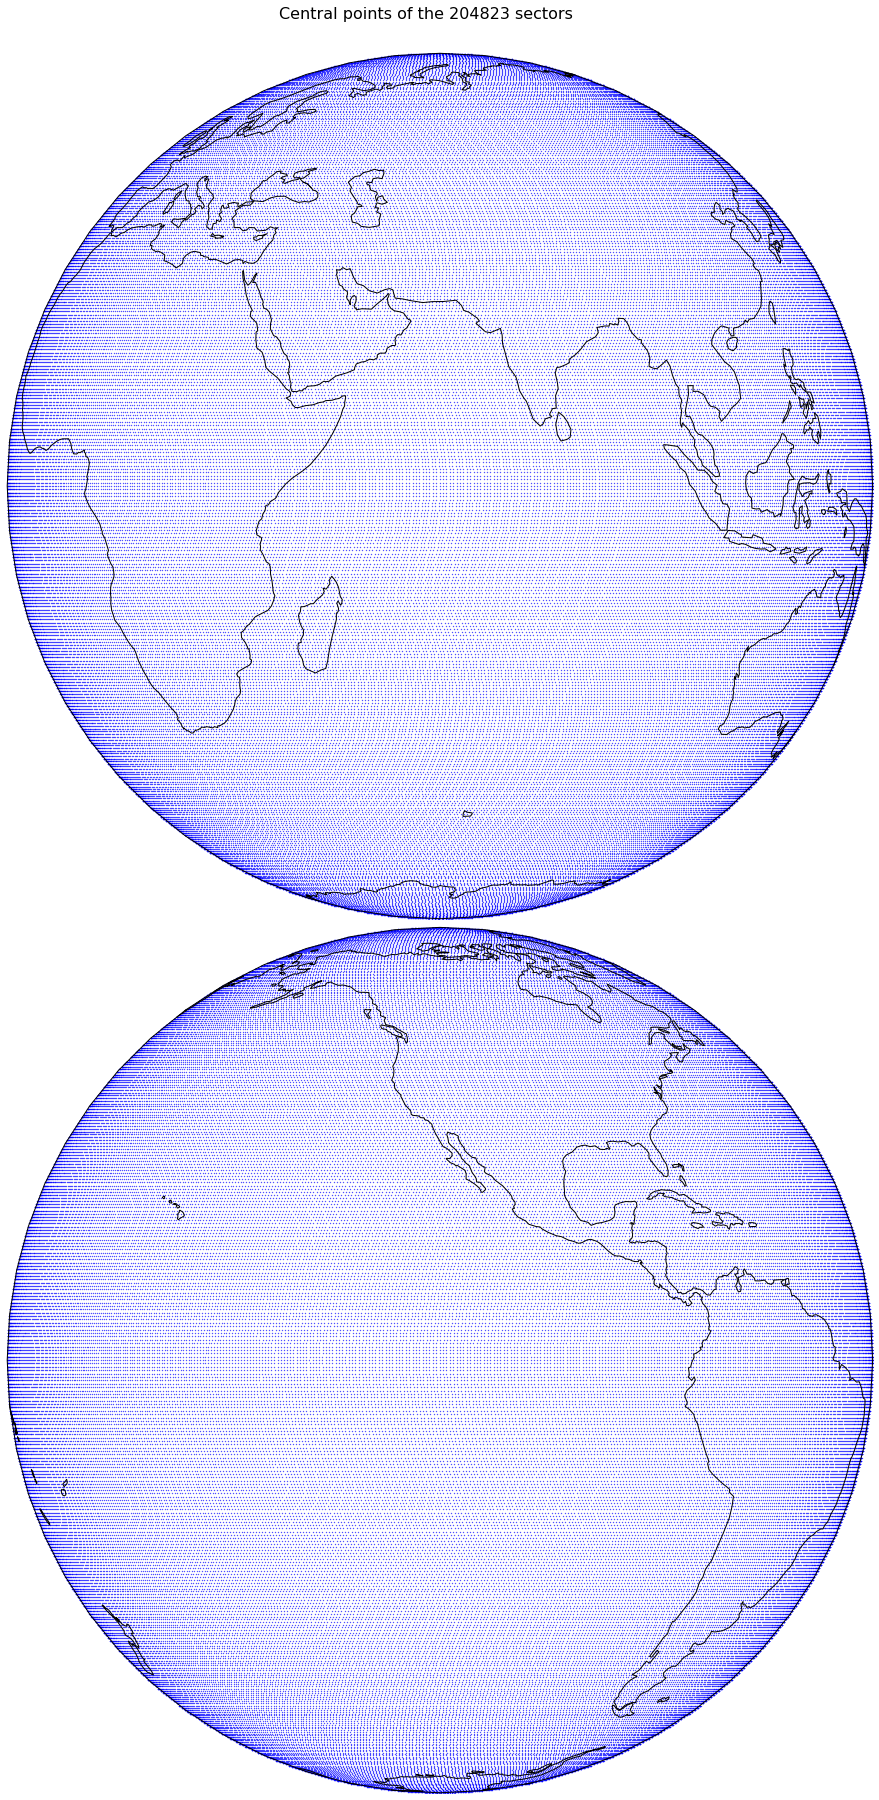

In [18]:
#mapping landslides around the world
#creating the figure and geoaxes
fig_map=plt.figure(figsize=(16,32))
fig_map.suptitle('Central points of the 204823 sectors',fontsize=16,y=0.9)
gs=fig_map.add_gridspec(nrows=2,ncols=1,wspace=0.05,hspace=0.01)

ax_map1=fig_map.add_subplot(gs[0,0],projection=ccrs.Orthographic(central_longitude=64))
ax_map1.coastlines()
ax_map1.set_global()

ax_map2=fig_map.add_subplot(gs[1,0],projection=ccrs.Orthographic(central_longitude=64+180))
ax_map2.coastlines()
ax_map2.set_global()

#mapping the landslides
on_face1=(sectors_df['lon_cen'].between(64-90,64+90))

x_face1=sectors_df.loc[on_face1,'lon_cen']
y_face1=sectors_df.loc[on_face1,'lat_cen']
x_face2=sectors_df.loc[~on_face1,'lon_cen']
y_face2=sectors_df.loc[~on_face1,'lat_cen']

ax_map1.scatter(x_face1,y_face1,s=0.1,c='blue',alpha=1,transform=ccrs.PlateCarree())

ax_map2.scatter(x_face2,y_face2,s=0.1,c='blue',alpha=1,transform=ccrs.PlateCarree())
plt.show()

## Building the database

Using Python Sqlite3 module, I built the following database:

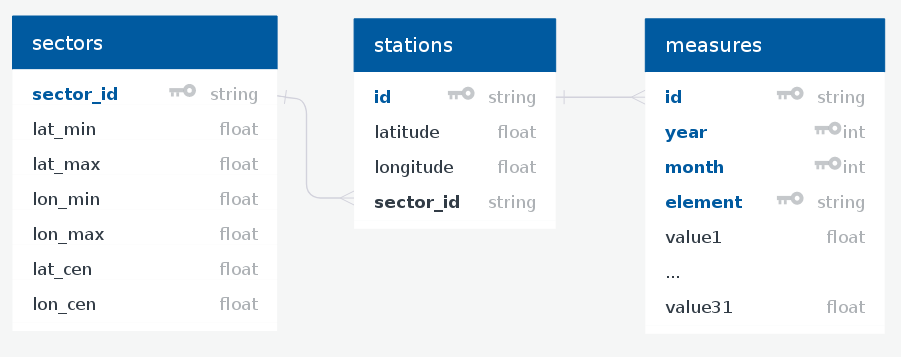

We already know the sectors. The stations are imported from the fixed width file 'ghcnd-stations.txt'. While the file includes a few more features to describre the stations, we are only interested in their latitude and longitude that we will use to aggregate their measures.

The measures were gathered from the 108081 station files into a single table wich is more convenient to handle. As said before, each line represents a full month of measure for one item. That's why we have the following composite primary key: 'id-year-month-element'. The value for each day is stored in a column 'valueX', X being the day number. For months with less than 31 days, the value is -9999 wich is also the value for missing data.

## Stations over space and time

*(All the following figures were created by querying the database and plotting the data with Matplotlib/Cartopy)*

As we saw, 108,081 stations are listed in the Global Historical Climatology Network-Daily database. But the actual number of stations working at the same time has been widely varying over time (see figure below). In fact, never more than 41,324 stations around the world have been active at the same time.

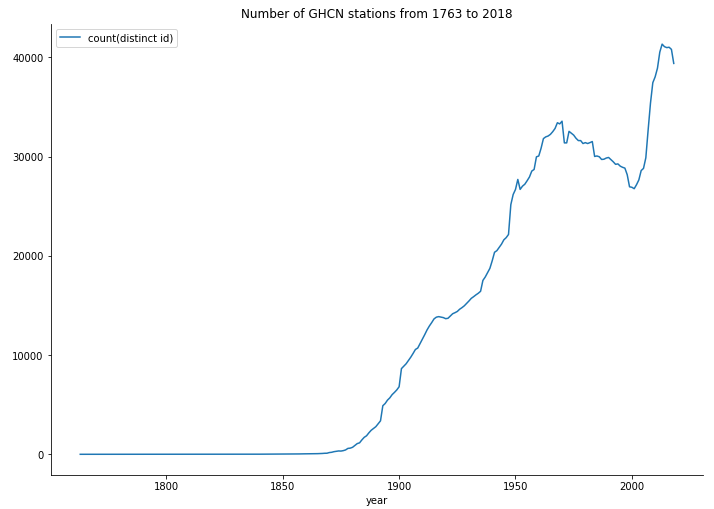

In addition, the geographical distribution of the stations is really uneven: most of them are or have been in the United-States (55%), Australia (16%), Canada (8%), Brazil (5.5%) and India (3.5%). 

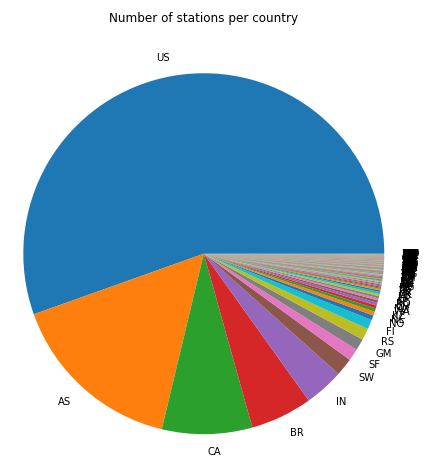

Let's use our sectors to see how the geographical density of the stations evolve over time:

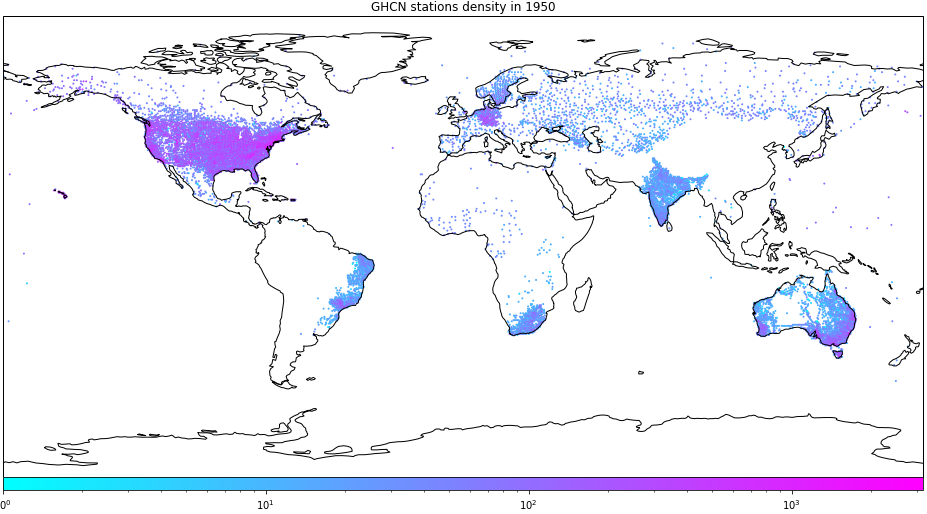
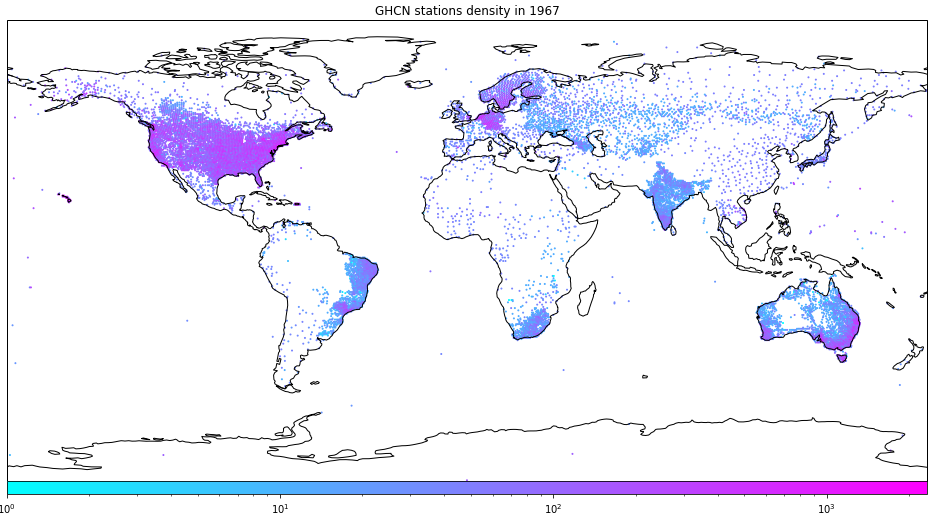
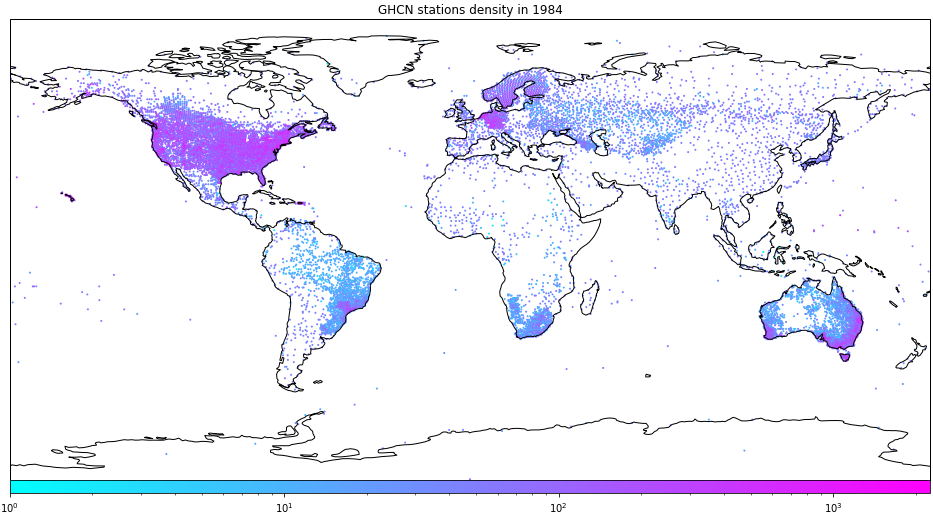
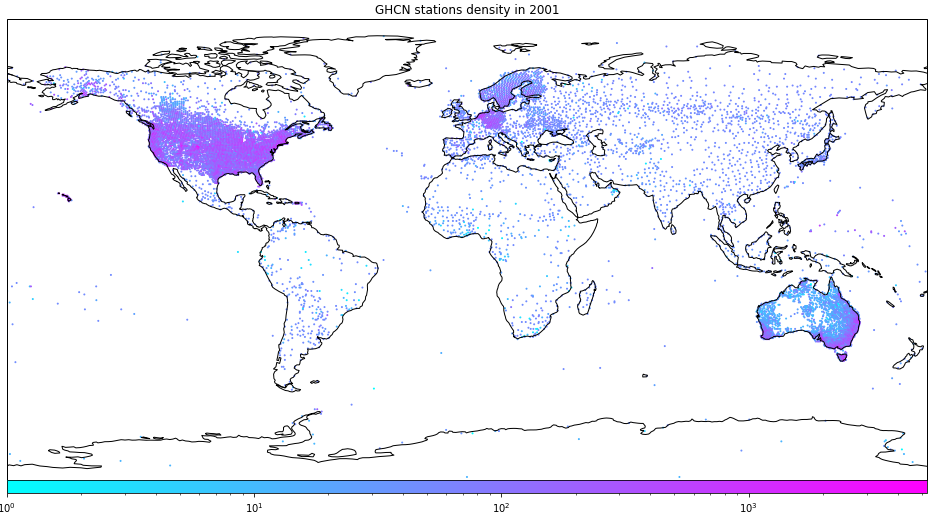
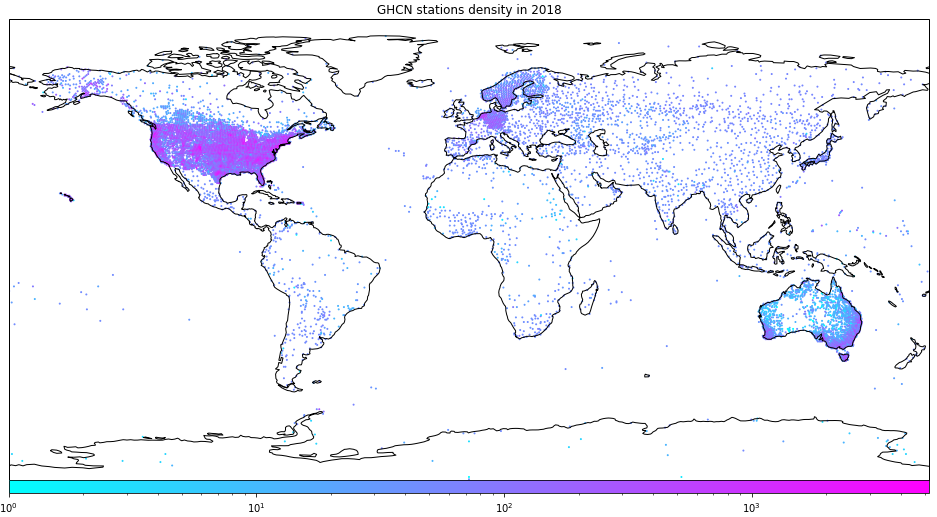

Theses maps reveal clearly that since 1950, the stations have been disappearing from India, Brazil and South Africa while remaining constant in density in the US, Australia, Germany and Sweden.

## Example of Python script to make a data visualization video 

The following example is a script callable from shell to make a video of one item between two dates:

## And now, a few videos

